<a href="https://colab.research.google.com/github/ZachLuttrell/UCSD_Capstone/blob/main/Multi_class_Semantic_Segmentation_of_Aerial_Imagery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Class Semantic Segmentation of Aerial Imagery

In this notebook we train a model to perform multi-class semantic segmentation on a dataset of aerial imagery captured over Dubai.  The dataset contains only a few images (less than 100) and their corresponding labels for a total of 6 distinct land-use classes.  We train our model to take in patches of imagery and produce prediction masks detailing which classes occur in which pixels of the images.

***DATASET***: https://www.kaggle.com/humansintheloop/semantic-segmentation-of-aerial-imagery

***ORIGINAL EXAMPLE***: https://github.com/bnsreenu/python_for_microscopists/tree/master/228_semantic_segmentation_of_aerial_imagery_using_unet

The dataset consists of aerial imagery of Dubai obtained by MBRSC satellites and annotated with pixel-wise semantic segmentation in 6 classes. The total volume of the dataset is 72 images grouped into 6 larger tiles. The classes are:

- Building: #3C1098
- Land (unpaved area): #8429F6
- Road: #6EC1E4
- Vegetation: #FEDD3A
- Water: #E2A929
- Unlabeled: #9B9B9B

**NOTE:**
- Video at: https://youtu.be/jvZm8REF2KY
- Explanation of using RGB masks: https://youtu.be/sGAwx4GMe4E

**NOTE:** Connect to a High-RAM Runtime

* Click on Runtime > Change Runtime Type > enable High-RAM

In [1]:
# install patchify
!pip install patchify

import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler

**Mount To Google Drive to Retrieve Dataset**

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


**Set A Few Variables To Prepare For Pre-Processing**

In [4]:
scaler = MinMaxScaler()

root_directory = '/gdrive/My Drive/Semantic Segmentation/Semantic segmentation dataset/'

patch_size = 256 # Here we set our minimum patch size.

**Crop and Patchify The Images**

Below is some math detailing the total number of patches (sized 256x256 pixels) we can extract from our original imagery dataset which contains 72 images.

Using patchify, we get....
- Tile 1: 797 x 644 --> 768 x 512 --> 6
- Tile 2: 509 x 544 --> 512 x 256 --> 2
- Tile 3: 682 x 658 --> 512 x 512  --> 4
- Tile 4: 1099 x 846 --> 1024 x 768 --> 12
- Tile 5: 1126 x 1058 --> 1024 x 1024 --> 16
- Tile 6: 859 x 838 --> 768 x 768 --> 9
- Tile 7: 1817 x 2061 --> 1792 x 2048 --> 56
- Tile 8: 2149 x 1479 --> 1280 x 2048 --> 40
- Total 9 images in each folder * (145 patches) = 1305
- Total 1305 patches of size 256x256


In [5]:
# Read images from repsective 'images' subdirectory
# As all images are of different size we have 2 options, either resize or crop
# But, some images are too large and some small. Resizing will change the size of real objects.
# Therefore, we will crop them to a nearest size divisible by 256 and then
# divide all images into patches of 256x256x3.
image_dataset = []
for path, subdirs, files in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':   #Find all 'images' directories
        images = os.listdir(path)  #List of all image names in this subdirectory
        images = sorted(images)
        print(f'\npatchifying directory: {path}')
        for i, image_name in enumerate(images):
            if image_name.endswith(".jpg"):   #Only read jpg images...

                image = cv2.imread(path+"/"+image_name, 1)  #Read each image as RGB
                SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                image = np.array(image)

                #Extract patches from each image
                print(f"({i+1}) Now patchifying image: {path}/{image_name}")
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  # Step=256 for 256x256 patches means no overlap

                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):

                        single_patch_img = patches_img[i,j,:,:]

                        #Use minmaxscaler instead of just dividing by 255.
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)

                        #single_patch_img = (single_patch_img.astype('float32')) / 255.
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.
                        image_dataset.append(single_patch_img)

# Display total number of images in list
print(f'\nTotal Image Dataset Size: {len(image_dataset)} images')


patchifying directory: /gdrive/My Drive/Semantic Segmentation/Semantic segmentation dataset/Tile 8/images
(1) Now patchifying image: /gdrive/My Drive/Semantic Segmentation/Semantic segmentation dataset/Tile 8/images/image_part_001.jpg
(2) Now patchifying image: /gdrive/My Drive/Semantic Segmentation/Semantic segmentation dataset/Tile 8/images/image_part_002.jpg
(3) Now patchifying image: /gdrive/My Drive/Semantic Segmentation/Semantic segmentation dataset/Tile 8/images/image_part_003.jpg
(4) Now patchifying image: /gdrive/My Drive/Semantic Segmentation/Semantic segmentation dataset/Tile 8/images/image_part_004.jpg
(5) Now patchifying image: /gdrive/My Drive/Semantic Segmentation/Semantic segmentation dataset/Tile 8/images/image_part_005.jpg
(6) Now patchifying image: /gdrive/My Drive/Semantic Segmentation/Semantic segmentation dataset/Tile 8/images/image_part_006.jpg
(7) Now patchifying image: /gdrive/My Drive/Semantic Segmentation/Semantic segmentation dataset/Tile 8/images/image_par

**Crop and Patchify Masks**

In [6]:
# Now do the same as above for masks
mask_dataset = []
for path, subdirs, files in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':   #Find all 'images' directories
        masks = os.listdir(path)  #List of all image names in this subdirectory
        masks = sorted(masks)
        print(f'\npatchifying directory: {path}')
        for i, mask_name in enumerate(masks):
            if mask_name.endswith(".png"):   #Only read png images... (masks in this dataset)

                mask = cv2.imread(path+"/"+mask_name, 1)  #Read each image as Grey (or color but remember to map each color to an integer)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                mask = np.array(mask)

                #Extract patches from each image
                print(f"({i}) Now patchifying mask: {path}/{mask_name}")
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap

                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):

                        single_patch_mask = patches_mask[i,j,:,:]
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                        single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.
                        mask_dataset.append(single_patch_mask)

# display size of mask dataset
print(f'\nTotal Mask Dataset Size: {len(image_dataset)} masks')


patchifying directory: /gdrive/My Drive/Semantic Segmentation/Semantic segmentation dataset/Tile 8/masks
(0) Now patchifying mask: /gdrive/My Drive/Semantic Segmentation/Semantic segmentation dataset/Tile 8/masks/image_part_001.png
(1) Now patchifying mask: /gdrive/My Drive/Semantic Segmentation/Semantic segmentation dataset/Tile 8/masks/image_part_002.png
(2) Now patchifying mask: /gdrive/My Drive/Semantic Segmentation/Semantic segmentation dataset/Tile 8/masks/image_part_003.png
(3) Now patchifying mask: /gdrive/My Drive/Semantic Segmentation/Semantic segmentation dataset/Tile 8/masks/image_part_004.png
(4) Now patchifying mask: /gdrive/My Drive/Semantic Segmentation/Semantic segmentation dataset/Tile 8/masks/image_part_005.png
(5) Now patchifying mask: /gdrive/My Drive/Semantic Segmentation/Semantic segmentation dataset/Tile 8/masks/image_part_006.png
(6) Now patchifying mask: /gdrive/My Drive/Semantic Segmentation/Semantic segmentation dataset/Tile 8/masks/image_part_007.png
(7) N

**Send The Image and Mask Lists to NP Arrays**

In [7]:
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

**Convert Hex Values to RGB Arrays**

In [8]:
# convert each hex code to RGB
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#')
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation = 'FEDD3A'.lstrip('#')
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#')
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#')
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

label = single_patch_mask

**Visual Inspection of the Image/Mask Pairs**

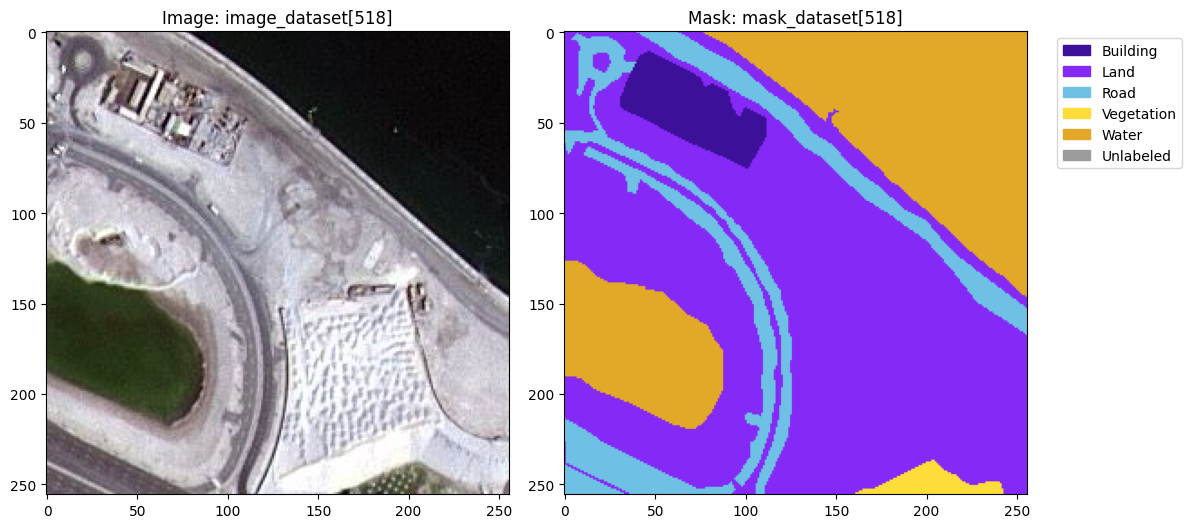

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random
import numpy as np

# dictionary to store color values for the legend.
colors = {
    "Building": '#3C1098',
    "Land": '#8429F6',
    "Road": '#6EC1E4',
    "Vegetation": '#FEDD3A',
    "Water": '#E2A929',
    "Unlabeled": '#9B9B9B'
}

# Convert hex to RGB
for label, hex in colors.items():
    # Corrected to strip the '#' character before conversion
    colors[label] = np.array(tuple(int(hex.strip('#')[i:i+2], 16) for i in (0, 2, 4)))

# Visualization
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))

# Display Image
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.title(f"Image: image_dataset[{image_number}]")

# Display Mask with legend
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.title(f"Mask: mask_dataset[{image_number}]")

# Create a legend
legend_labels = [mpatches.Patch(color=np.array(colors[label])/255.0, label=label) for label in colors]
plt.legend(handles=legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


**Extract The Labels**

In [12]:
# Now replace RGB w integer values to be used as labels.
#Find pixels with combination of RGB for the above defined arrays...
#if matches then replace all values in that pixel with a specific integer
def rgb_to_2D_label(label):
    """
    Supply our label masks as input in RGB format.
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5

    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels

    return label_seg

labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)

labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)


print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 1 2 3 4 5]


**Visual Inspection of Image/Label Pairs**

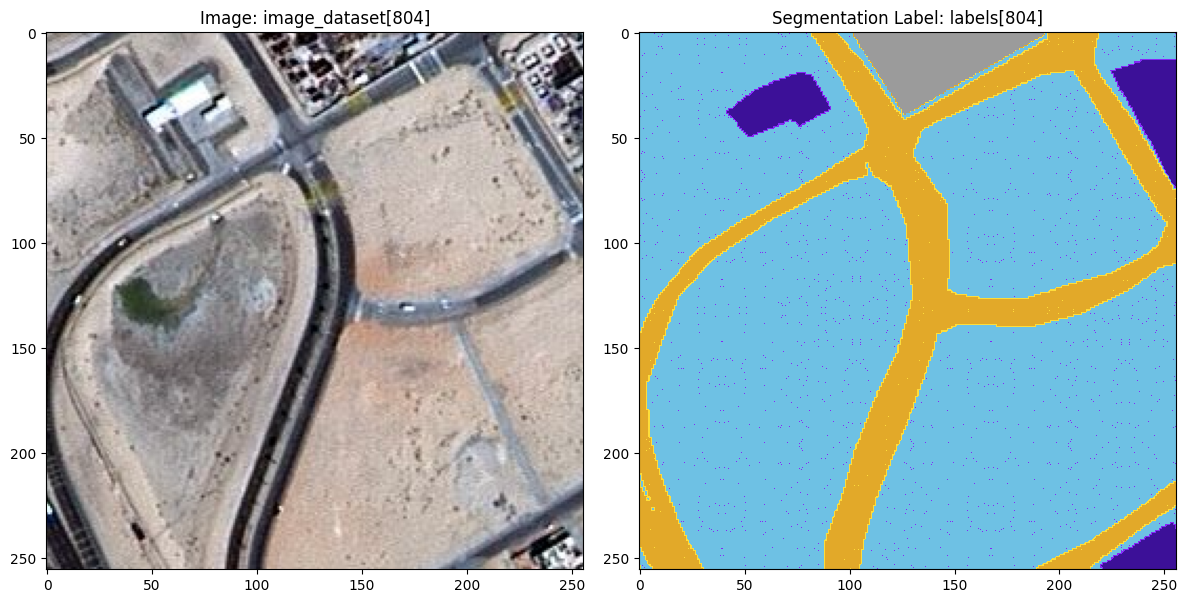

In [21]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import random
from matplotlib.colors import ListedColormap, BoundaryNorm

label_colors = np.array([
    [60, 16, 152],    # Building
    [132, 41, 246],   # Land
    [110, 193, 228],  # Road
    [254, 221, 58],   # Vegetation
    [226, 169, 41],   # Water
    [155, 155, 155]   # Unlabeled
]) / 255.0  # Normalize to [0,1]

# Adjusting the legend labels to include the placeholder
legend_labels = ['Building', 'Land', 'Road', 'Vegetation', 'Water', 'Unlabeled']

# Create a ListedColormap
cmap = ListedColormap(label_colors)

# Plotting
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))

# Display original image
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.title(f"Image: image_dataset[{image_number}]")

# Display the label image with the custom colormap
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0], cmap=cmap)
plt.title(f"Segmentation Label: labels[{image_number}]")

plt.tight_layout()
plt.show()


**Encode Labels & Perform Train/Test Split**

In [22]:
n_classes = len(np.unique(labels))
from keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

from sklearn.model_selection import train_test_split
# First, split into train and temp (temp will be further split into validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(image_dataset, labels_cat, test_size=0.2, random_state=42)

# Now split temp into validation and test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42)
print('Train/Test Split Sizes:')
print(f'X_train: {X_train.shape}')
print(f'X_val:   {X_val.shape}')
print(f'X_test:  {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_val:   {y_val.shape}')
print(f'y_test:  {y_test.shape}')

Train/Test Split Sizes:
X_train: (1044, 256, 256, 3)
X_val:   (182, 256, 256, 3)
X_test:  (79, 256, 256, 3)
y_train: (1044, 256, 256, 6)
y_val:   (182, 256, 256, 6)
y_test:  (79, 256, 256, 6)


**Define The Model Architecture, Loss Functions & Metrics**

Here we define a few functions describing a custom loss functions, metrics, and the model architecture (U-Net).

In [23]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras.backend import epsilon
import tensorflow as tf

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

def jaccard_index(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred, axis=(1,2,3))
    union = tf.reduce_sum(y_true + y_pred, axis=(1,2,3)) - intersection

    return (intersection + epsilon()) / (union + epsilon())

def weighted_dice_loss(weights):
    def dice_loss(y_true, y_pred):
        numerator = 2 * tf.reduce_sum(weights * y_true * y_pred, axis=(1,2,3))
        denominator = tf.reduce_sum(weights * (y_true + y_pred), axis=(1,2,3))

        return 1 - (numerator + epsilon()) / (denominator + epsilon())
    return dice_loss

def categorical_focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, epsilon(), 1. - epsilon())
        ce = -y_true * tf.math.log(y_pred)
        loss = alpha * tf.pow(1 - y_pred, gamma) * ce
        return tf.reduce_sum(loss, axis=-1)
    return focal_loss_fixed

def combined_loss(weights, gamma=2., alpha=.25):
    def loss(y_true, y_pred):
        return weighted_dice_loss(weights)(y_true, y_pred) + categorical_focal_loss(gamma, alpha)(y_true, y_pred)
    return loss

def simple_unet(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    inputs = Input(input_size)
    # Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(0.1)(p1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(0.1)(p2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(0.2)(p3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    p4 = Dropout(0.2)(p4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)

    # Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(0.2)(u6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(0.2)(u7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(0.1)(u8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(0.1)(u9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model


**Compile The Model**

In [24]:
from sklearn.utils.class_weight import compute_class_weight

# Compute the class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(np.ravel(labels, order='C')), y=np.ravel(labels, order='C'))
print(f'Weights: \n{class_weights}\n')

# Create and compile the model
model = simple_unet(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', jaccard_index])

"""# Here is an example utilizing the custom loss functions defined earlier. However, on first run, performance increases were neglible.
model.compile(optimizer='adam',
              loss=combined_loss(class_weights),
              metrics=['accuracy', jaccard_index])"""

# Show a model summary.
model.summary()

Weights: 
[ 1.21840647  0.31278179  1.78506885  1.63018853  1.28221878 34.95017654]

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 dropout 

**Train & Save The Model**

In [28]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)

# Train the Model
history = model.fit(
    X_train, y_train,
    batch_size=16,
    verbose=1,
    epochs=100,
    validation_data=(X_val, y_val),
    shuffle=False,
    callbacks=[early_stopping]
)

# Save the model for later use.
model_save_path = os.path.join(root_directory, 'simple_unet')
model.save(model_save_path)

Epoch 1/100
66/66 [==============================] - 93s 1s/step - loss: 1.0697 - accuracy: 0.5883 - jaccard_index: 0.3664 - val_loss: 0.9620 - val_accuracy: 0.6727 - val_jaccard_index: 0.4607
Epoch 2/100
66/66 [==============================] - 92s 1s/step - loss: 0.8315 - accuracy: 0.7031 - jaccard_index: 0.4691 - val_loss: 0.7495 - val_accuracy: 0.7404 - val_jaccard_index: 0.5295
Epoch 3/100
66/66 [==============================] - 92s 1s/step - loss: 0.7605 - accuracy: 0.7312 - jaccard_index: 0.4981 - val_loss: 0.7210 - val_accuracy: 0.7470 - val_jaccard_index: 0.5409
Epoch 4/100
66/66 [==============================] - 91s 1s/step - loss: 0.7244 - accuracy: 0.7420 - jaccard_index: 0.5142 - val_loss: 0.6818 - val_accuracy: 0.7676 - val_jaccard_index: 0.5424
Epoch 5/100
66/66 [==============================] - 91s 1s/step - loss: 0.6992 - accuracy: 0.7509 - jaccard_index: 0.5250 - val_loss: 0.6426 - val_accuracy: 0.7796 - val_jaccard_index: 0.5563
Epoch 6/100
66/66 [================

**Visualize Model Training Details**

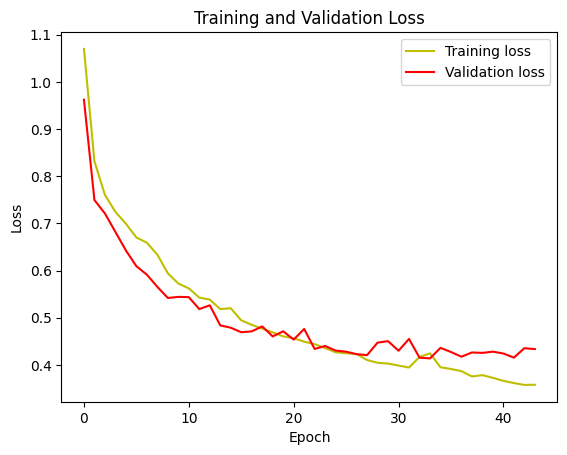

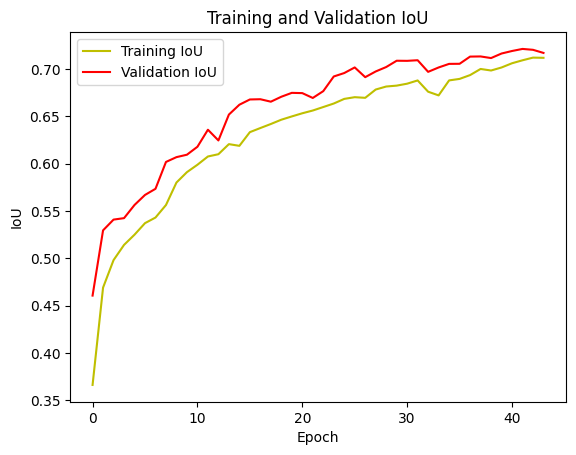

In [29]:
# Plot training & validation loss values
plt.plot(history.history['loss'], 'y', label='Training loss')
plt.plot(history.history['val_loss'], 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training & validation IoU
plt.plot(history.history['jaccard_index'], 'y', label='Training IoU')
plt.plot(history.history['val_jaccard_index'], 'r', label='Validation IoU')
plt.title('Training and Validation IoU')
plt.ylabel('IoU')
plt.xlabel('Epoch')
plt.legend()
plt.show()

**Evaluate The Model**

In [30]:
# Predict on the test set
y_pred = model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=3)
y_test_argmax = np.argmax(y_test, axis=3)

# Calculate the Mean IoU using TensorFlow's Keras API
from tensorflow.keras.metrics import MeanIoU
n_classes = 6
iou_keras = MeanIoU(num_classes=n_classes)
iou_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", iou_keras.result().numpy())

3/3 [==============================] - 2s 487ms/step
Mean IoU = 0.6063173


**Visualize Model Predictions**

1/1 [==============================] - 0s 44ms/step


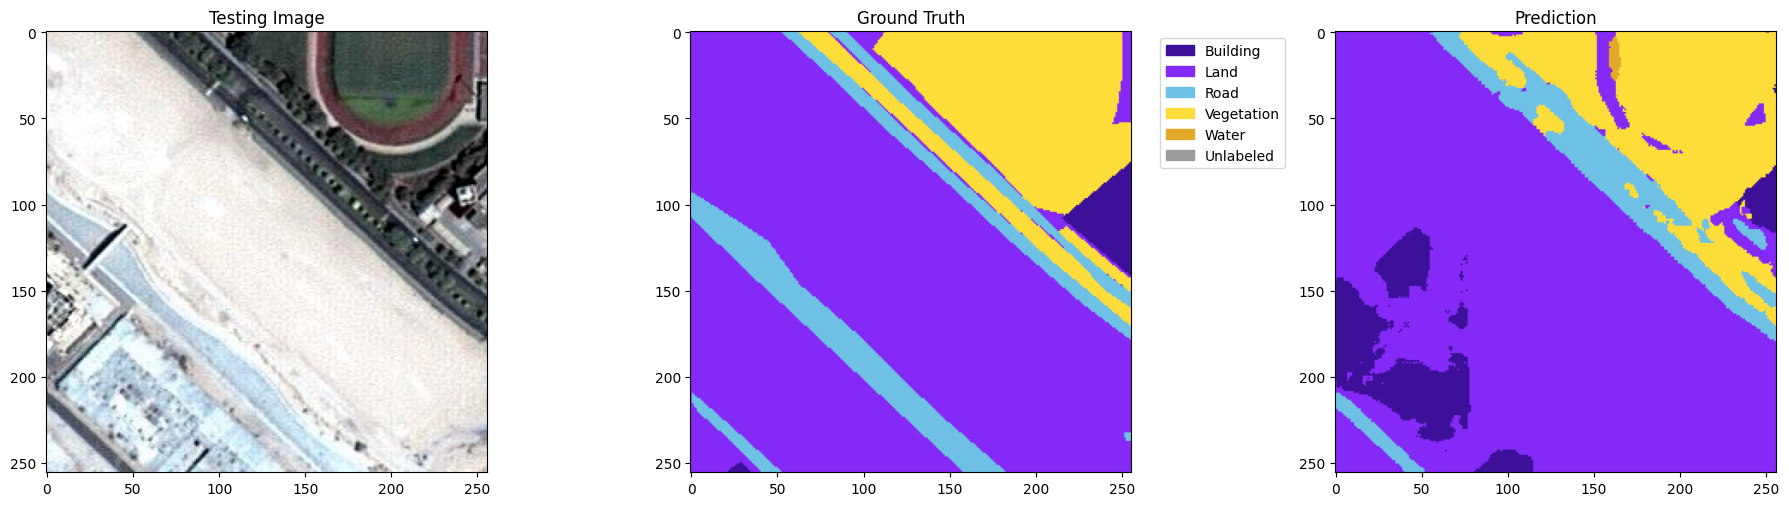

In [32]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import random

# Function to convert both prediction and ground truth to RGB for visualization
def label_to_rgb(label, colors, n_classes=6):
    """Convert label array to RGB image using the color mapping."""
    rgb_img = np.zeros((label.shape[0], label.shape[1], 3), dtype=np.uint8)
    for class_id in range(n_classes):  # Assuming class IDs are 0-indexed
        rgb_img[label == class_id] = colors[list(colors.keys())[class_id]]
    return rgb_img

# Select a random image from the test set
test_img_number = random.randint(0, len(X_test) - 1)
test_img = X_test[test_img_number]
ground_truth = y_test_argmax[test_img_number]
test_img_input = np.expand_dims(test_img, 0)
prediction = model.predict(test_img_input)
predicted_img = np.argmax(prediction, axis=3)[0,:,:]

# Convert the ground truth and predicted image to RGB
ground_truth_rgb = label_to_rgb(ground_truth, colors)
predicted_rgb = label_to_rgb(predicted_img, colors)

plt.figure(figsize=(18, 6))

# Display the original image
plt.subplot(131)
plt.imshow(test_img)
plt.title('Testing Image')

# Display the ground truth with legend
plt.subplot(132)
plt.imshow(ground_truth_rgb)
plt.title('Ground Truth')
legend_labels = [mpatches.Patch(color=np.array(colors[label])/255.0, label=label) for label in colors.keys()]
plt.legend(handles=legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the prediction
plt.subplot(133)
plt.imshow(predicted_rgb)
plt.title('Prediction')

plt.tight_layout()
plt.show()
